<a href="https://colab.research.google.com/github/SachinBiswas7/-Bangla-Text-Violence-Nature-and-Target-Classification/blob/main/task_2_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import re
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler  # Import RandomOverSampler
import unicodedata

In [10]:
df=pd.read_csv("Dataset.csv")
df.head()

,SL,Emotion,Text,Year,Racial Biases,Hatred Percentage,Depression Percentage
0,1,disgust,নির্বাচনের আগের রাতে সুষ্টু শান্তিপূর্ণ ভাবে ভ...,2016,NaN,NaN,NaN
1,2,disgust,জনগণ মনের আনন্দে নিজেদের ভোট কাস্ট করে দেশদ্রো...,2016,NaN,NaN,NaN
2,3,angry,ভেজাল নির্বাচন ।,2016,NaN,NaN,NaN
3,4,happy,বিএনপি ও রাজাকার সমর্থকরা হেরে গেলে দেশের জন্য...,2016,NaN,NaN,NaN
4,5,angry,"সূক্ষ্ম কারচুপি বলে এতদিন একটা কথার কথা ছিল, এ...",2016,NaN,NaN,NaN


In [11]:
# Divide the dataset into train, dev, and test sets
train_df = df.sample(frac=0.8, random_state=42)  # 80% for training
remaining_df = df.drop(train_df.index)  # Remaining 20%

# Split the remaining 20% into dev (50% of remaining) and test (50% of remaining)
dev_df = remaining_df.sample(frac=0.5, random_state=42)  # 50% of remaining for development
test_df = remaining_df.drop(dev_df.index)  # The rest for testing

# Now you have train_df (80%), dev_df (10%), and test_df (10%)


In [12]:
# Load BanglaBERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")

# Load Dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df[['Text', 'Emotion']]
    return df



In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# ✅ Encode labels once before oversampling
label_encoder = LabelEncoder()

# Apply encoding to the entire dataset
train_df["Emotion"] = label_encoder.fit_transform(train_df["Emotion"])
dev_df["Emotion"] = label_encoder.transform(dev_df["Emotion"])
test_df["Emotion"] = label_encoder.transform(test_df["Emotion"])

def oversample_dataset(df):
    """Applies Random Oversampling to balance the dataset."""
    # Drop NaN values
    df = df.dropna(subset=['Text', 'Emotion'])

    ros = RandomOverSampler(random_state=42)
    texts_resampled, labels_resampled = ros.fit_resample(df["Text"].values.reshape(-1, 1), df["Emotion"].values)

    return pd.DataFrame({"Text": texts_resampled.flatten().tolist(), "Emotion": labels_resampled.tolist()})

# ✅ Apply oversampling AFTER fixing NaN issues
train_df = oversample_dataset(train_df)
dev_df = oversample_dataset(dev_df)
test_df = oversample_dataset(test_df)


In [14]:
import re
import unicodedata

# ✅ Preprocessing Function
def preprocess_text(text):
    text = unicodedata.normalize('NFKC', text)  # Normalize Unicode text
    text = re.sub(r'[০-৯]', '[NUMBER]', text)  # Replace Bangla numbers
    text = re.sub(r'http\S+|www\S+', '[URL]', text)  # Replace URLs
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Remove non-Bangla characters
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    return text

# ✅ Apply preprocessing
train_df["text"] = train_df["Text"].astype(str).apply(preprocess_text)
dev_df["text"] = dev_df["Text"].astype(str).apply(preprocess_text)
test_df["text"] = test_df["Text"].astype(str).apply(preprocess_text)


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader

# ✅ Define Dataset Class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=70):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])  # Ensure text is a string
        label = int(self.labels[idx])  # Ensure label is an integer

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),  # Shape: (seq_len)
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)  # Ensure correct type
        }

# ✅ Prepare datasets
train_dataset = TextDataset(train_df["text"].tolist(), train_df["Emotion"].tolist(), tokenizer)
dev_dataset = TextDataset(dev_df["text"].tolist(), dev_df["Emotion"].tolist(), tokenizer)
test_dataset = TextDataset(test_df["text"].tolist(), test_df["Emotion"].tolist(), tokenizer)

# ✅ Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [16]:
import torch
import torch.nn as nn

class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, input_dim, output_dim, routing_iterations=3):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.routing_iterations = routing_iterations

        # Initialize capsule transformation weights
        self.weights = nn.Parameter(torch.randn(1, num_capsules, input_dim, output_dim))

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, num_input_capsules, input_dim)
        Returns: Tensor of shape (batch_size, num_capsules, output_dim)
        """
        batch_size = x.shape[0]

        # Expand input for batch matrix multiplication
        x = x.unsqueeze(1).expand(batch_size, self.num_capsules, -1, -1)

        # Compute u_hat (predictions)
        u_hat = torch.matmul(x, self.weights)  # Shape: (batch_size, num_capsules, num_input_capsules, output_dim)

        # Initialize routing logits (b_ij)
        b_ij = torch.zeros(batch_size, self.num_capsules, u_hat.shape[2], 1).to(x.device)

        for _ in range(self.routing_iterations):
            c_ij = torch.nn.functional.softmax(b_ij, dim=1)  # Softmax across capsule dimension
            s_j = (c_ij * u_hat).sum(dim=2)  # Weighted sum
            v_j = self.squash(s_j)  # Apply squash function

            # Update routing logits (b_ij)
            b_ij = b_ij + (u_hat * v_j.unsqueeze(2)).sum(dim=-1, keepdim=True)

        return v_j  # Shape: (batch_size, num_capsules, output_dim)

    @staticmethod
    def squash(tensor):
        """
        Squash function for capsule output normalization.
        """
        norm = torch.norm(tensor, dim=-1, keepdim=True) ** 2
        return (norm / (1 + norm)) * (tensor / (torch.sqrt(norm + 1e-8)))


In [17]:
import torch
import torch.nn as nn
from transformers import AutoModel

class CAPTAINModel(nn.Module):
    def __init__(self, num_classes=6):
        super(CAPTAINModel, self).__init__()
        # Load pre-trained BanglaBERT
        self.bert = AutoModel.from_pretrained("csebuetnlp/banglabert")

        # Initialize Capsule Layer
        self.capsule = CapsuleLayer(num_capsules=8, input_dim=768, output_dim=16)

        # Additional layers for classification
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.batch_norm = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids, attention_mask):
        # Get the output of BERT (last_hidden_state: (batch_size, seq_len, 768))
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

        # Apply max pooling over the sequence dimension to reduce the sequence length
        pooled_output = torch.max(bert_output, dim=1)[0]  # Shape: (batch_size, 768)

        # Pass the pooled output to the capsule layer
        caps_output = self.capsule(pooled_output)

        # Flatten the capsule output for the fully connected layers
        flat_output = self.flatten(caps_output)

        # Feed through fully connected layers with Batch Normalization and Dropout
        x = self.batch_norm(torch.relu(self.fc1(flat_output)))
        x = self.dropout(x)

        # Final output layer (logits)
        logits = self.fc2(x)

        return torch.nn.functional.log_softmax(logits, dim=1)



In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import os
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
import re
import unicodedata
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# Set CUDA debugging mode
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# **Step 1: Apply Random Oversampling to Balance the Datasets**
def oversample_dataset(df):
    # Drop rows where 'text' or 'label' is NaN
    df = df.dropna(subset=['Text', 'Emotion'])

    # Ensure labels are integers using label encoder
    label_encoder = LabelEncoder()
    df["Emotion"] = label_encoder.fit_transform(df["Emotion"])

    ros = RandomOverSampler(random_state=42)
    texts, labels = df["Text"].values.reshape(-1, 1), df["Emotion"].values

    texts_resampled, labels_resampled = ros.fit_resample(texts, labels)

    balanced_df = pd.DataFrame({"Text": texts_resampled.flatten(), "Emotion": labels_resampled})
    return balanced_df

# Apply oversampling after fixing NaN issues
train_df = oversample_dataset(train_df)
dev_df = oversample_dataset(dev_df)
test_df = oversample_dataset(test_df)

# **Step 2: Preprocessing Function**
def preprocess_text(Text):
    text = unicodedata.normalize('NFKC', Text)  # Normalize Unicode text
    text = re.sub(r'[০-৯]', '[NUMBER]', Text)  # Replace Bangla numbers
    text = re.sub(r'http\S+|www\S+', '[URL]', Text)  # Replace URLs
    text = re.sub(r'[^\u0980-\u09FF\s]', '', Text)  # Remove non-Bangla characters
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    return text

train_df["text"] = train_df["Text"].apply(preprocess_text)
dev_df["text"] = dev_df["Text"].apply(preprocess_text)
test_df["text"] = test_df["Text"].apply(preprocess_text)

# **Step 3: Define Dataset Class**
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=70):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# **Step 4: Define CAPTAIN Model (Capsule Network + BanglaBERT)**
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, input_dim, output_dim, routing_iterations=3):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.routing_iterations = routing_iterations
        self.weights = nn.Parameter(torch.randn(num_capsules, input_dim, output_dim))

    def forward(self, x):
        x = x.unsqueeze(1).expand(-1, self.num_capsules, -1, -1)
        u_hat = torch.matmul(x, self.weights)

        b_ij = torch.zeros(u_hat.shape[0], self.num_capsules, u_hat.shape[2]).to(x.device)

        for _ in range(self.routing_iterations):
            c_ij = torch.nn.functional.softmax(b_ij, dim=1)
            s_j = (c_ij.unsqueeze(-1) * u_hat).sum(dim=2)
            v_j = self.squash(s_j)
            b_ij = b_ij + (u_hat * v_j.unsqueeze(2)).sum(dim=-1)

        return v_j

    @staticmethod
    def squash(tensor):
        norm = (tensor ** 2).sum(dim=-1, keepdim=True)
        scale = norm / (1 + norm)
        return scale * tensor / torch.sqrt(norm + 1e-8)

class CAPTAINModel(nn.Module):
    def __init__(self, num_classes=6):
        super(CAPTAINModel, self).__init__()
        self.bert = AutoModel.from_pretrained("csebuetnlp/banglabert")
        self.capsule = CapsuleLayer(num_capsules=8, input_dim=768, output_dim=16)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.batch_norm = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        caps_output = self.capsule(bert_output)
        flat_output = self.flatten(caps_output)
        x = self.batch_norm(torch.relu(self.fc1(flat_output)))
        x = self.dropout(x)
        logits = self.fc2(x)
        return torch.nn.functional.log_softmax(logits, dim=1)

# **Step 5: Training Setup**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CAPTAINModel().to(device)

# Optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Set up learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# **Step 6: Training Loop**
def train_model():
    epochs = 20
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss, correct, total = 0, 0, 0  # Initialize loss and accuracy variables

        # Iterate over the training batches
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)  # Ensure the labels are correct

            # Check if labels are within valid range
            num_classes = 6  # Replace with your actual number of classes
            if (labels < 0).any() or (labels >= num_classes).any():
                print(f"Invalid label detected: {labels}")
                raise ValueError(f"Invalid label detected in batch!")

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass: Get the model outputs
            outputs = model(input_ids, attention_mask)

            # Check output shape
            if outputs.shape[1] != num_classes:
                print(f"Output shape mismatch. Expected {num_classes}, but got {outputs.shape[1]}")
                raise ValueError(f"Output shape mismatch!")

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Check for NaN or Inf in loss
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"NaN or Inf detected in loss at epoch {epoch+1}")
                raise ValueError("NaN or Inf in loss!")

            # Backward pass: Compute gradients
            loss.backward()

            # Clip gradients to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Optimizer step: Update the model parameters
            optimizer.step()

            # Track the total loss
            total_loss += loss.item()

            # Track accuracy
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        # Step the scheduler
        scheduler.step()

        # Print loss and accuracy for the epoch
        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = correct / total
        print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# **Step 7: Prepare DataLoaders**
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")

train_dataset = TextDataset(train_df["text"].tolist(), train_df["Emotion"].tolist(), tokenizer)
dev_dataset = TextDataset(dev_df["text"].tolist(), dev_df["Emotion"].tolist(), tokenizer)
test_dataset = TextDataset(test_df["text"].tolist(), test_df["Emotion"].tolist(), tokenizer)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Start training
train_model()


pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]


Epoch 1/20: 100%|██████████| 906/906 [06:28<00:00,  2.68it/s]
                                                             

Epoch 1 - Loss: 1.5414, Accuracy: 0.3842


Epoch 2 - Loss: 0.8287, Accuracy: 0.7376


Epoch 3 - Loss: 0.5259, Accuracy: 0.8514


Epoch 4 - Loss: 0.3900, Accuracy: 0.8951


Epoch 5 - Loss: 0.3179, Accuracy: 0.9159


Epoch 6 - Loss: 0.2452, Accuracy: 0.9360


Epoch 7 - Loss: 0.2065, Accuracy: 0.9437


Epoch 8 - Loss: 0.1877, Accuracy: 0.9483


Epoch 9 - Loss: 0.1723, Accuracy: 0.9518


Epoch 10 - Loss: 0.1617, Accuracy: 0.9531


Epoch 11 - Loss: 0.1383, Accuracy: 0.9572


Epoch 12 - Loss: 0.1273, Accuracy: 0.9587


Epoch 13 - Loss: 0.1231, Accuracy: 0.9599


Epoch 14 - Loss: 0.1148, Accuracy: 0.9599


Epoch 15 - Loss: 0.1132, Accuracy: 0.9608


Epoch 16 - Loss: 0.1073, Accuracy: 0.9620


Epoch 17 - Loss: 0.0987, Accuracy: 0.9615


Epoch 18 - Loss: 0.0964, Accuracy: 0.9629


Epoch 19 - Loss: 0.0958, Accuracy: 0.9626


Epoch 20 - Loss: 0.0934, Accuracy: 0.9641


In [ ]:
print(f"Input IDs shape: {input_ids.shape}, Attention Mask shape: {attention_mask.shape}")
print(f"Output shape: {outputs.shape}")

In [20]:


# **Step 8: Model Evaluation**
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels)

# **Print Classification Report with 4-digit Precision**
print("Classification Report:")
print(classification_report(true_labels, predictions, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.8772    0.8578    0.8674       633
           1     0.8591    0.9052    0.8815       633
           2     0.9124    0.9384    0.9252       633
           3     0.9169    0.8720    0.8939       633
           4     0.8126    0.7536    0.7820       633
           5     0.8601    0.9131    0.8858       633

    accuracy                         0.8734      3798
   macro avg     0.8731    0.8734    0.8727      3798
weighted avg     0.8731    0.8734    0.8727      3798



In [ ]:
#save the model
torch.save(model.state_dict(), 'model.pth')

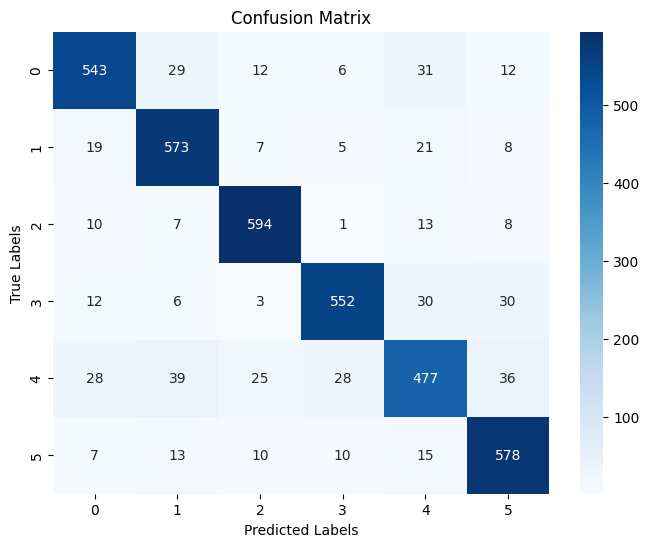

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


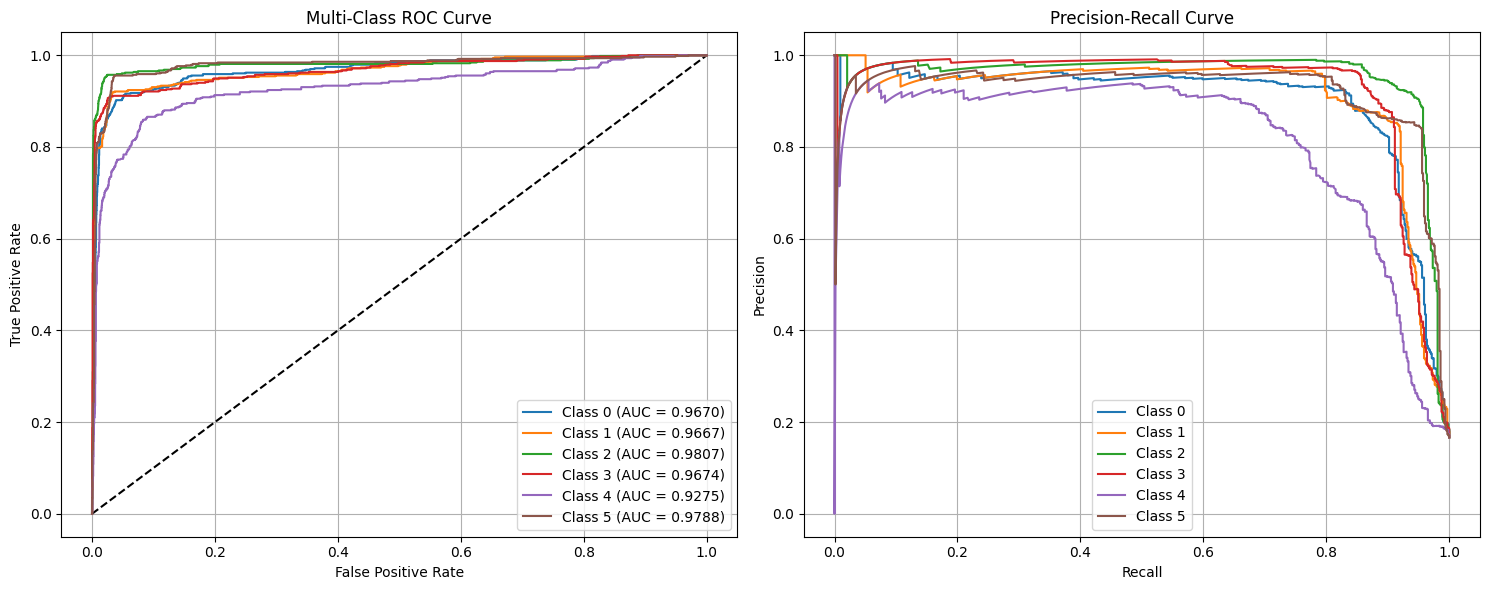

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import numpy as np
import torch

# *Step 1: Convert True Labels to One-Hot Encoding (Required for Multi-Class)*
num_classes = len(set(true_labels))  # Number of classes
true_labels_one_hot = label_binarize(true_labels, classes=np.arange(num_classes))

# *Step 2: Get Softmax Probabilities for ROC & PR Curves*
model.eval()
all_probs = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)
        outputs = model(input_ids, attention_mask)
        probs = torch.exp(outputs).cpu().numpy()  # Convert log-softmax to probabilities
        all_probs.extend(probs)

all_probs = np.array(all_probs)

# *Step 3 & 4: Plot ROC and Precision-Recall Curves Side by Side*
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Create 1 row, 2 columns

# ---- Plot ROC Curve ----
axes[0].set_title("Multi-Class ROC Curve")
axes[0].plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].grid()

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.4f})")

axes[0].legend()

# ---- Plot Precision-Recall Curve ----
axes[1].set_title("Precision-Recall Curve")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].grid()

for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(true_labels_one_hot[:, i], all_probs[:, i])
    axes[1].plot(recall, precision, label=f"Class {i}")

axes[1].legend()

plt.tight_layout()  # Adjust layout for better visualization
plt.show()

# banglabert with stopwords

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import re
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler  # Import RandomOverSampler
import unicodedata

# Load BanglaBERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")

# Load Dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df[['text', 'label']]
    return df

train_df = pd.read_csv("train_modified.csv")
dev_df = pd.read_csv("dev_modified.csv")
test_df = pd.read_csv("test_modified.csv")

# Step 1: Apply Random Oversampling to Balance the Datasets
def oversample_dataset(df):
    # Drop rows where 'text' or 'label' is NaN
    df = df.dropna(subset=['text', 'label'])

    # Ensure labels are integers
    df["label"] = df["label"].astype(int)

    ros = RandomOverSampler(random_state=42)
    texts, labels = df["text"].values.reshape(-1, 1), df["label"].values

    texts_resampled, labels_resampled = ros.fit_resample(texts, labels)

    balanced_df = pd.DataFrame({"text": texts_resampled.flatten(), "label": labels_resampled})
    return balanced_df

# Apply oversampling after fixing NaN issues
train_df = oversample_dataset(train_df)
dev_df = oversample_dataset(dev_df)
test_df = oversample_dataset(test_df)



# **Step 2: Preprocessing Function**
def preprocess_text(text):
    text = unicodedata.normalize('NFKC', text)  # Normalize Unicode text
    text = re.sub(r'[০-৯]', '[NUMBER]', text)  # Replace Bangla numbers
    text = re.sub(r'http\S+|www\S+', '[URL]', text)  # Replace URLs
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Remove non-Bangla characters
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    return text

train_df["text"] = train_df["text"].apply(preprocess_text)
dev_df["text"] = dev_df["text"].apply(preprocess_text)
test_df["text"] = test_df["text"].apply(preprocess_text)

# **Step 3: Define Dataset Class**
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=70):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Prepare datasets
train_dataset = TextDataset(train_df["text"].tolist(), train_df["label"].tolist(), tokenizer)
dev_dataset = TextDataset(dev_df["text"].tolist(), dev_df["label"].tolist(), tokenizer)
test_dataset = TextDataset(test_df["text"].tolist(), test_df["label"].tolist(), tokenizer)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# **Step 4: Capsule Network Layer**
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, input_dim, output_dim, routing_iterations=3):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.routing_iterations = routing_iterations
        self.weights = nn.Parameter(torch.randn(num_capsules, input_dim, output_dim))

    def forward(self, x):
        x = x.unsqueeze(1).expand(-1, self.num_capsules, -1, -1)
        u_hat = torch.matmul(x, self.weights)

        b_ij = torch.zeros(u_hat.shape[0], self.num_capsules, u_hat.shape[2]).to(x.device)

        for _ in range(self.routing_iterations):
            c_ij = torch.nn.functional.softmax(b_ij, dim=1)
            s_j = (c_ij.unsqueeze(-1) * u_hat).sum(dim=2)
            v_j = self.squash(s_j)
            b_ij = b_ij + (u_hat * v_j.unsqueeze(2)).sum(dim=-1)

        return v_j

    @staticmethod
    def squash(tensor):
        norm = (tensor ** 2).sum(dim=-1, keepdim=True)
        scale = norm / (1 + norm)
        return scale * tensor / torch.sqrt(norm + 1e-8)

# **Step 5: Define CAPTAIN Model**
class CAPTAINModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CAPTAINModel, self).__init__()
        self.bert = AutoModel.from_pretrained("csebuetnlp/banglabert")
        self.capsule = CapsuleLayer(num_capsules=8, input_dim=768, output_dim=16)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.batch_norm = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.8)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        caps_output = self.capsule(bert_output)
        flat_output = self.flatten(caps_output)
        x = self.batch_norm(torch.relu(self.fc1(flat_output)))
        x = self.dropout(x)
        logits = self.fc2(x)
        return torch.nn.functional.log_softmax(logits, dim=1)

# **Step 6: Training Setup**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CAPTAINModel().to(device)

optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# **Step 7: Training Loop**
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)

        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    scheduler.step()
    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}, Accuracy: {correct/total:.4f}")

# **Step 8: Model Evaluation**
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels)

# **Print Classification Report with 4-digit Precision**
print("Classification Report:")
print(classification_report(true_labels, predictions, digits=4))


#banglabert without stopwords

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import re
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler  # Import RandomOverSampler
import unicodedata

# Load BanglaBERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")

# Load Dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df[['text', 'label']]
    return df

train_df = pd.read_csv("train_modified.csv")
dev_df = pd.read_csv("dev_modified.csv")
test_df = pd.read_csv("test_modified.csv")

# Load Stopwords
def load_stopwords(file_path="stopwords_bangla.csv"):
    stopwords_df = pd.read_csv(file_path)
    stopwords_list = set(stopwords_df["words"].dropna().tolist())  # Ensure no NaN values
    return stopwords_list

STOPWORDS = load_stopwords()  # Load stopwords once

# Step 1: Apply Random Oversampling to Balance the Datasets
def oversample_dataset(df):
    # Drop rows where 'text' or 'label' is NaN
    df = df.dropna(subset=['text', 'label'])

    # Ensure labels are integers
    df["label"] = df["label"].astype(int)

    ros = RandomOverSampler(random_state=42)
    texts, labels = df["text"].values.reshape(-1, 1), df["label"].values

    texts_resampled, labels_resampled = ros.fit_resample(texts, labels)

    balanced_df = pd.DataFrame({"text": texts_resampled.flatten(), "label": labels_resampled})
    return balanced_df

# Step 2: Preprocessing Function (Now includes Stopword Removal)
def preprocess_text(text):
    text = unicodedata.normalize('NFKC', text)  # Normalize Unicode text
    text = re.sub(r'[০-৯]', '[NUMBER]', text)  # Replace Bangla numbers
    text = re.sub(r'http\S+|www\S+', '[URL]', text)  # Replace URLs
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Remove non-Bangla characters

    # Remove stopwords
    words = text.split()
    words = [word for word in words if word not in STOPWORDS]
    text = ' '.join(words)

    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    return text

# Apply preprocessing and oversampling
train_df = oversample_dataset(train_df)
dev_df = oversample_dataset(dev_df)
test_df = oversample_dataset(test_df)

train_df["text"] = train_df["text"].apply(preprocess_text)
dev_df["text"] = dev_df["text"].apply(preprocess_text)
test_df["text"] = test_df["text"].apply(preprocess_text)


# **Step 3: Define Dataset Class**
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=70):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Prepare datasets
train_dataset = TextDataset(train_df["text"].tolist(), train_df["label"].tolist(), tokenizer)
dev_dataset = TextDataset(dev_df["text"].tolist(), dev_df["label"].tolist(), tokenizer)
test_dataset = TextDataset(test_df["text"].tolist(), test_df["label"].tolist(), tokenizer)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# **Step 4: Capsule Network Layer**
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, input_dim, output_dim, routing_iterations=3):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.routing_iterations = routing_iterations
        self.weights = nn.Parameter(torch.randn(num_capsules, input_dim, output_dim))

    def forward(self, x):
        x = x.unsqueeze(1).expand(-1, self.num_capsules, -1, -1)
        u_hat = torch.matmul(x, self.weights)

        b_ij = torch.zeros(u_hat.shape[0], self.num_capsules, u_hat.shape[2]).to(x.device)

        for _ in range(self.routing_iterations):
            c_ij = torch.nn.functional.softmax(b_ij, dim=1)
            s_j = (c_ij.unsqueeze(-1) * u_hat).sum(dim=2)
            v_j = self.squash(s_j)
            b_ij = b_ij + (u_hat * v_j.unsqueeze(2)).sum(dim=-1)

        return v_j

    @staticmethod
    def squash(tensor):
        norm = (tensor ** 2).sum(dim=-1, keepdim=True)
        scale = norm / (1 + norm)
        return scale * tensor / torch.sqrt(norm + 1e-8)

# **Step 5: Define CAPTAIN Model**
class CAPTAINModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CAPTAINModel, self).__init__()
        self.bert = AutoModel.from_pretrained("csebuetnlp/banglabert")
        self.capsule = CapsuleLayer(num_capsules=8, input_dim=768, output_dim=16)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.batch_norm = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        caps_output = self.capsule(bert_output)
        flat_output = self.flatten(caps_output)
        x = self.batch_norm(torch.relu(self.fc1(flat_output)))
        x = self.dropout(x)
        logits = self.fc2(x)
        return torch.nn.functional.log_softmax(logits, dim=1)

# **Step 6: Training Setup**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CAPTAINModel().to(device)

optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# **Step 7: Training Loop**
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)

        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    scheduler.step()
    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}, Accuracy: {correct/total:.4f}")

# **Step 8: Model Evaluation**
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels)

# **Print Classification Report with 4-digit Precision**
print("Classification Report:")
print(classification_report(true_labels, predictions, digits=4))


In [ ]:
!pip install --upgrade pip
!pip install --upgrade tensorflow torch transformers
!pip install tqdm



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import re
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler
import unicodedata

# Load XLM-RoBERTa Tokenizer
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")

# Load Dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df[['text', 'label']]
    return df.dropna(subset=['text', 'label'])  # Drop missing values

train_df = load_data("train_modified.csv")
dev_df = load_data("dev_modified.csv")
test_df = load_data("test_modified.csv")

# Apply Oversampling
def oversample_dataset(df):
    df["label"] = df["label"].astype(int)  # Ensure labels are integers
    ros = RandomOverSampler(random_state=42)

    texts, labels = df["text"].values.reshape(-1, 1), df["label"].values
    texts_resampled, labels_resampled = ros.fit_resample(texts, labels)

    return pd.DataFrame({"text": texts_resampled.flatten(), "label": labels_resampled})

train_df = oversample_dataset(train_df)  # Oversample only training data

# Preprocessing Function
def preprocess_text(text):
    text = unicodedata.normalize('NFKC', text)
    text = re.sub(r'[০-৯]', '[NUMBER]', text)  # Replace Bengali numbers
    text = re.sub(r'http\S+|www\S+', '[URL]', text)  # Replace URLs
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Keep only Bengali text
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply Preprocessing
for df in [train_df, dev_df, test_df]:
    df["text"] = df["text"].apply(preprocess_text)

# Dataset Class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=70):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])  # Ensure it's a string
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(),  # Removed squeeze(0) to avoid shape issues
            "attention_mask": encoding["attention_mask"].squeeze(),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Prepare datasets and DataLoaders
batch_size = 32
train_dataset = TextDataset(train_df["text"].tolist(), train_df["label"].tolist(), tokenizer)
dev_dataset = TextDataset(dev_df["text"].tolist(), dev_df["label"].tolist(), tokenizer)
test_dataset = TextDataset(test_df["text"].tolist(), test_df["label"].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Capsule Network Layer
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, input_dim, output_dim, routing_iterations=3):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.routing_iterations = routing_iterations
        self.weights = nn.Parameter(torch.randn(num_capsules, input_dim, output_dim))

    def forward(self, x):
        x = x.unsqueeze(1).expand(-1, self.num_capsules, -1, -1)
        u_hat = torch.matmul(x, self.weights)

        b_ij = torch.zeros(u_hat.shape[0], self.num_capsules, u_hat.shape[2]).to(x.device)

        for _ in range(self.routing_iterations):
            c_ij = torch.nn.functional.softmax(b_ij, dim=1)
            s_j = (c_ij.unsqueeze(-1) * u_hat).sum(dim=2)
            v_j = self.squash(s_j)
            b_ij = b_ij + (u_hat * v_j.unsqueeze(2)).sum(dim=-1)

        return v_j

    @staticmethod
    def squash(tensor):
        norm = (tensor ** 2).sum(dim=-1, keepdim=True)
        scale = norm / (1 + norm)
        return scale * tensor / torch.sqrt(norm + 1e-8)

# Define CAPTAIN Model
class CAPTAINModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CAPTAINModel, self).__init__()
        self.bert = AutoModel.from_pretrained("xlm-roberta-large")
        self.capsule = CapsuleLayer(num_capsules=8, input_dim=768, output_dim=16)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.batch_norm = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        caps_output = self.capsule(bert_output)
        flat_output = self.flatten(caps_output)
        x = self.batch_norm(torch.relu(self.fc1(flat_output)))
        x = self.dropout(x)
        logits = self.fc2(x)
        return torch.nn.functional.log_softmax(logits, dim=1)

# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CAPTAINModel().to(device)

optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# Training Loop
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)

        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    scheduler.step()
    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}, Accuracy: {correct/total:.4f}")

# Model Evaluation
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(preds)

print("Classification Report:")
print(classification_report(true_labels, predictions, digits=4))
